In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from simsimpy import *
import random

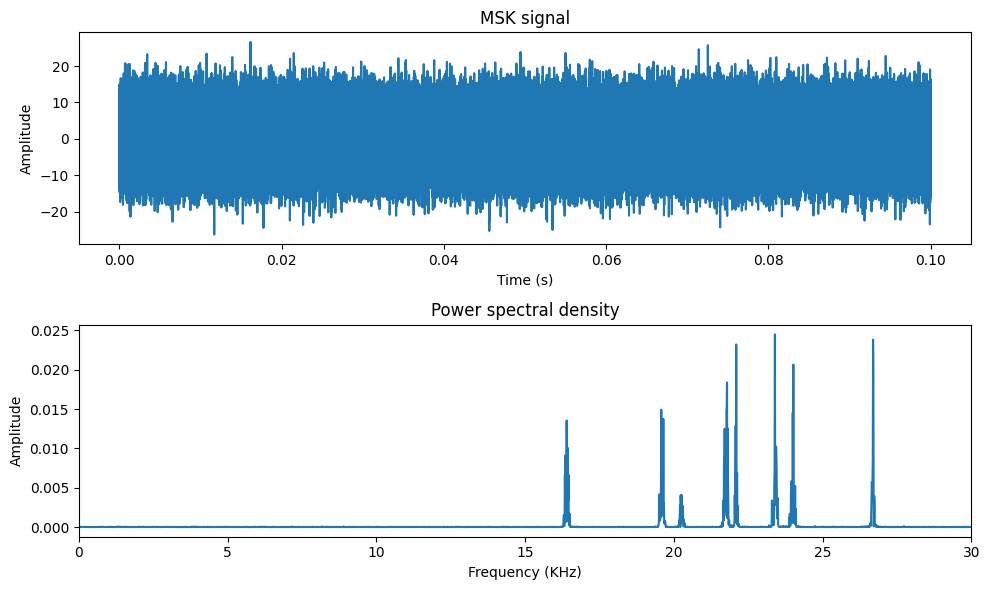

In [2]:
carriers = np.array([16.40e3, 19.60e3, 20.27e3, 21.75e3, 22.10e3, 23.40e3, 24.00e3, 26.70e3])
#carriers = np.array([16.0e3, 19.0e3, 20.e3, 21.e3, 22.e3, 23.e3, 24.00e3, 26.0e3])
baudrate = np.array([200,     200,     200,     200,     100,     200,     200,     100])
T_symbols = 1/baudrate
fs = 4e6#4e6
time = 0.1

t = np.linspace(0, time, int(fs*time))

# Generate the signal
msk_data_single = np.zeros((len(carriers), len(t)))
msk_data = np.zeros_like(t)
offset = np.zeros_like(carriers)
phase_offset = np.zeros_like(carriers)
amplitude = np.zeros_like(carriers)
data_true = np.zeros((len(carriers),int(time/T_symbols[0])))
phase = np.zeros((len(carriers),len(t)))
for i, (carrier, T) in enumerate(zip(carriers, T_symbols)):    
    offset[i] = random.uniform(0, T_symbols[i])
    phase_offset[i] = random.uniform(-np.pi, np.pi)
    amplitude[i] = random.uniform(0.5, 2)
    #offset[i] = 0
    #phase_offset[i] = 0
    #amplitude[i] = 1
    msk_data_single[i], _, data_temp, phase[i] = generate_msk(int(time/T), 0.5, T, carrier, fs, offset=offset[i], phase_offset=phase_offset[i], amplitude=amplitude[i])
    msk_data += msk_data_single[i]
    data_true[i,0:int(time/T)] = data_temp[0:int(time/T)]
# Add noise
msk_data += np.random.normal(0, 5, msk_data.shape)

# calculate fft
f, fft_msk_data = signal.periodogram(msk_data, fs, nfft=len(msk_data))

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

axs[0].plot(t, msk_data)
axs[0].set_ylabel('Amplitude')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('MSK signal')


axs[1].plot(f/1e3, fft_msk_data)#10*np.log10(Pxx))
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Frequency (KHz)')
axs[1].set_title('Power spectral density')
axs[1].set_xlim(0, 30)
plt.tight_layout()


c:\Users\claes\miniconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
c:\Users\claes\miniconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\claes\miniconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


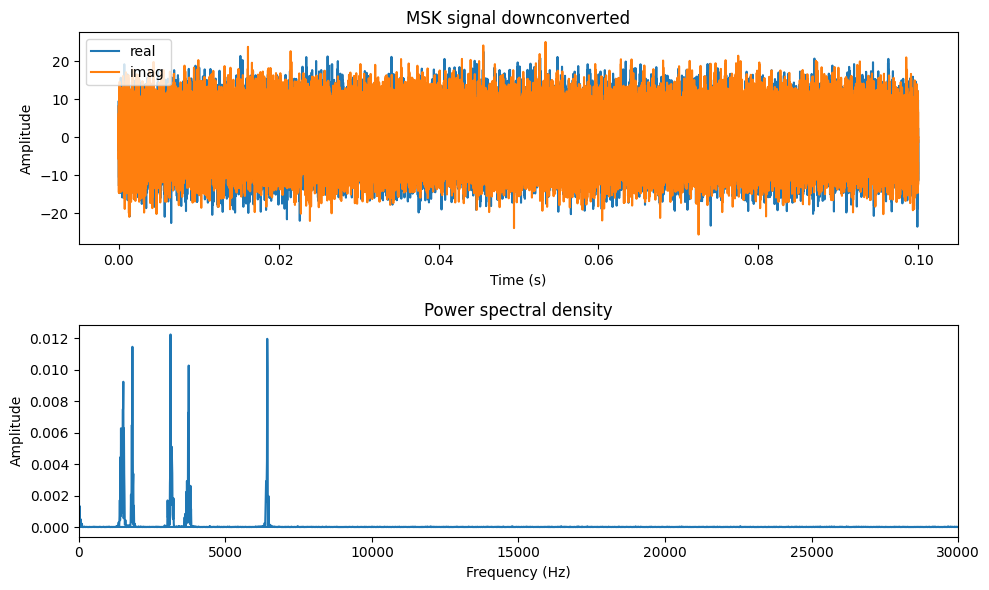

In [3]:

msk_data_down = np.zeros((len(carriers), len(t)), dtype=complex)
for i, (carrier, T) in enumerate(zip(carriers, T_symbols)):
    msk_data_down[i] = msk_data*np.exp(-1j*2*np.pi*carrier*t)


# calculate fft
fft_msk_data_down = np.zeros((len(carriers), len(t)), dtype=complex)
for i in range(len(carriers)):
    f, fft_msk_data_down[i] = signal.periodogram(msk_data_down[i], fs, nfft=len(msk_data_down[i]))

#f, fft_msk_data_down = signal.periodogram(msk_data_down, fs, nfft=len(msk_data_down))

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

axs[0].plot(t, msk_data_down[2].real, label='real')
axs[0].plot(t, msk_data_down[2].imag, label='imag')
axs[0].set_ylabel('Amplitude')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('MSK signal downconverted')
axs[0].legend()

axs[1].plot(f, fft_msk_data_down[2])#10*np.log10(Pxx))
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_title('Power spectral density')
axs[1].set_xlim(0, 30000)

plt.tight_layout()

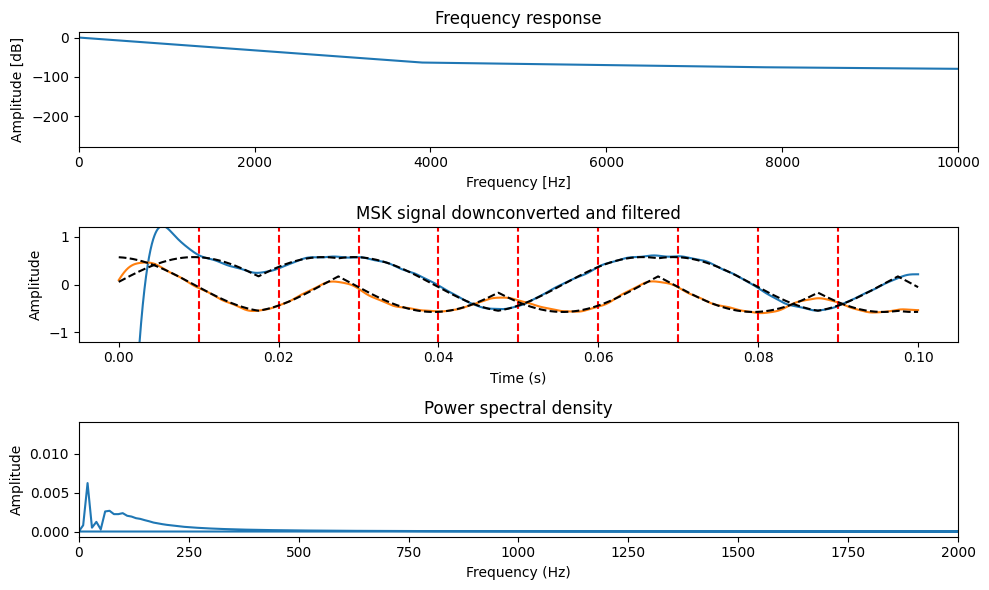

In [11]:
sos = signal.butter(2,0.00005, 'low', output='sos')
sos = signal.butter(2,1/T, 'low', output='sos', fs=fs)
w, h = signal.sosfreqz(sos, fs=fs)

index = 4

sos = signal.butter(2,1/T_symbols[index], 'low', output='sos', fs=fs)

msk_data_down_filtered = np.zeros_like(msk_data_down)
for i in range(len(carriers)):
    msk_data_down_filtered[i] = signal.sosfiltfilt(sos, msk_data_down[i]) 

fft_msk_data_down_filtered = np.zeros_like(fft_msk_data_down)
for i in range(len(carriers)):
    f, fft_msk_data_down_filtered[i] = signal.periodogram(msk_data_down_filtered[i], fs, nfft=len(msk_data_down_filtered[i]))
#f, fft_msk_data_down_filtered = signal.periodogram(msk_data_down_filtered, fs, nfft=len(msk_data_down_filtered))

fig, axs = plt.subplots(3, 1, figsize=(10, 6))

axs[0].plot(w, 20 * np.log10(np.abs(h)))
axs[0].set_ylabel('Amplitude [dB]')
axs[0].set_xlabel('Frequency [Hz]')
axs[0].set_title('Frequency response')
axs[0].set_xlim(0, 10e3)

axs[1].plot(t, msk_data_down_filtered[index].real)
axs[1].plot(t, msk_data_down_filtered[index].imag)
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Time (s)')
axs[1].set_title('MSK signal downconverted and filtered')
# vertical line at every symbol
for i in range(1, int(time/T_symbols[index])):
    axs[1].axvline(x=i*T_symbols[index], color='r', linestyle='--')
axs[1].set_ylim(-1.2, 1.2)
axs[1].plot(t, amplitude[index]*1/2*np.cos(-2*np.pi*carriers[index]*offset[index] + phase[index] + phase_offset[index]), 'k--')
axs[1].plot(t, amplitude[index]*1/2*np.sin(-2*np.pi*carriers[index]*offset[index] + phase[index] + phase_offset[index]), 'k--')

axs[2].plot(f, fft_msk_data_down_filtered[index])#10*np.log10(Pxx))
axs[2].set_ylabel('Amplitude')
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_title('Power spectral density')
axs[2].set_xlim(0, 2e3)

plt.tight_layout()
